In [1]:
import pandas  as pd
import matplotlib.pyplot as plt
import numpy   as np
import seaborn as sns 

plt.style.use('dark_background')

Друзі, вітаю вас! Сьогодні я хочу поділитися з вами моїм рішенням цього тестового завдання. Це завдання з геймдеву. Весь хід роботи і мої думки я буду писати майже в кожній ячейці. Хочу зазначити, що я вчуся на своїх помилках і роблю висновки щодо аналізу даних шляхом читання статей та перегляду відео.Я завжди відкритий до критики та підказок.

Опис завдання Вам потрібно дослідити дані про проходження гравцями рівнів match3-ігри та виконати такі завдання:

Завдання 1
Запропонувати метрику, що описує складність рівнів, та розрахувати її.

Завдання 2
За результатами попереднього завдання розділити рівні на групи за складністю та зробити висновок про щільність розташування складних рівнів у грі.
Завдання 3
Розрахувати "воронку" проходження рівнів новим користувачем після встановлення гри.
Також ми хотіли б отримати від вас коментар щодо виконання тестового завдання. Він не повинен бути дуже великим. Нам цікаво було б дізнатися:

приблизну оцінку часу, який ви витратили виконання завдання;
коментарі щодо сформованої метрики (п1): чому дана метрика буде показовою;
чи виникали проблеми під час виконання тестового завдання.
Вхідні дані – файл plr_smpl_attempts.csv.gz, що містить лог подій за певний проміжок часу за першими 500 рівнями у грі. Файл містить чотири колонки:
uid – унікальний id гравця;
action - 'completed' для успішної спроби проходження рівня, 'failed' для неуспішної;
level — рівень, на якому сталася подія;
event_time — event_time/1000 є unix timestamp часу отримання події.


Як ми бачимо, це гра. Я пишу цей текст вже після написання самого коду. Перш за все, я хочу зазначити, що це лише вибірка даних за один місяць, про що ми з вами скоро побачимо. Тому не слід розглядати це як повну вибірку за всю історію.

In [2]:
df = pd.read_csv('C:/Users/tuf/Downloads/plr_smpl_attempts.csv.gz', sep = ';')

In [3]:
df.head()

,uid,action,level,event_time
0,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
1,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
2,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
3,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
4,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640


In [4]:
df = df.rename(columns = {'uid':'user_id'})

In [5]:
df.head()

,user_id,action,level,event_time
0,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
1,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
2,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
3,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
4,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640


In [6]:
df.user_id.value_counts()

user_id
TEFwVmU4cTQyMzk0MjI3MTAyMDEzMQ    2352
bHVFZ05rTFAyNTk0MjI3MTAyMTE3MA    2324
R1R6Z0FMNUwzMTUxMzI3MTAyMjEyMQ    2255
dG82b3RtSzg3MzgyMzI3MTAyMTE3MA    2098
dW1kZzY1d1E0MDQyMDE3MTAyMTE3MQ    2013
                                  ... 
Y2VGMURhSVAyMjIxMjI3MTAyMjE0MQ       1
MVFNMmtnSDgwMjgwNzE3MTAyMTE1MA       1
ems2UFVscmw3NTYyMDI3MTAyMDE3Mg       1
NXpLQnBudWg4NTMyNjE3MTAyMjEyMA       1
VFNrWXM1WEgwMTIwMDA3MTAyMDEzMg       1
Name: count, Length: 196088, dtype: int64

Бачимо, що пропущених значень у нас немає.

In [7]:
df.isna().mean()

user_id       0.0
action        0.0
level         0.0
event_time    0.0
dtype: float64

Тут ми бачимо гістограму розподілу наших рівнів. Зразу ми можемо сказати, що є пік на середніх рівнях, а також на початкових. Подальше, кількість людей, які доходять до кінця, зменшується

<Axes: >

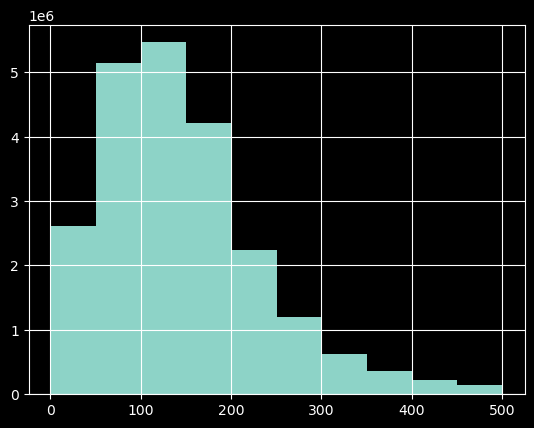

In [8]:
df.level.hist()

In [10]:
df.head()

,user_id,action,level,event_time
0,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
1,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
2,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
3,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
4,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640


У нас є два основні результати: успішно пройдений рівень або невдачна спроба.

In [11]:
df.action.value_counts()

action
failed       18744535
completed     3486679
Name: count, dtype: int64

ми замінемо текст на 0 та 1, в цьому випадку за 1 я візьму те що рівень не пройдено

In [12]:
df['action_bool'] = df.action.replace('failed',1).replace('completed',0)

In [13]:
df.head()

,user_id,action,level,event_time,action_bool
0,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640,1
1,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640,1
2,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640,1
3,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640,1
4,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640,1


я назвав метрику 'hard_rate' це числа які показують наскільки тяжкий є наш рівень гри

In [14]:
level_stat = df.groupby('level')['action_bool']\
    .agg(['count','mean'])\
    .sort_values('mean',ascending=False)\
    .rename(columns = {'count':'count_of_users','mean':'hard_rate'})\
    

In [15]:
level_stat.head()

,count_of_users,hard_rate
level,,
267,70197,0.942932
130,248240,0.941536
85,233400,0.937494
465,8396,0.936636
199,120153,0.933227


візуалізуємо це. Бачимо що в середньому в один момент підіймається складність рівней, а потім вона є приблизно рівномірною, 
як варіант можливо можна висунути таку гіпотезу що розробники хочуть щоб був саме баланс, легче, потів тяжче, щоб не так користувачі 
покидали нашу гру

<Axes: xlabel='level', ylabel='hard_rate'>

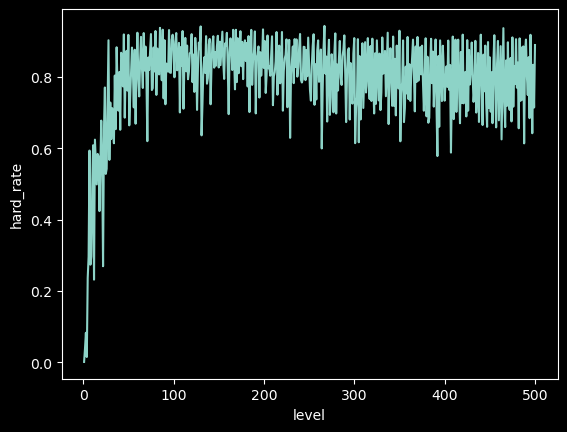

In [61]:
sns.lineplot(level_stat.hard_rate)

логічно припустити, що чим більше рівень (чим складніше), тим менше стає людей, складність все ж таки стає більшою, суддячи з логіки

<Axes: xlabel='level', ylabel='count_of_users'>

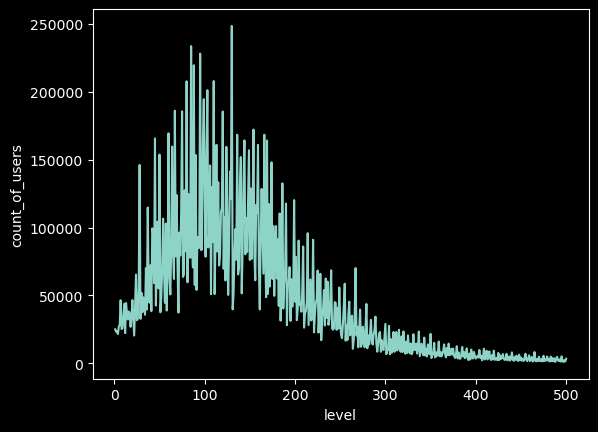

In [62]:
sns.lineplot(level_stat.count_of_users)

На цьому єтапі згідно з завдання потрібно розділити на складні рівні або нескладні.
Завдання 2 За результатами попереднього завдання розділити рівні на групи за складністю та зробити висновок про щільність розташування складних рівнів у грі.

Далі я хочу запропонувати свій варіант клаифікування на складні та легкі. Я просто візьму процентилі, та розібью на 4 групи, а саме 
hard, medium, very_hard, easy. Чогось замислуватого тут я не придумав.. А щодо щільності складних рівнів ми вже тут бачимо, що вони черегуються з 
легкими, але далі більше

In [63]:
level_stat.hard_rate.quantile(0.25)

0.7338747755357965

In [64]:
level_stat.hard_rate.quantile(0.50)

0.8157636207991663

In [65]:
level_stat.hard_rate.quantile(0.75)

0.8824679862997109

In [66]:
level_stat.hard_rate.quantile(0.90)

0.9094576429489196

In [67]:
df.shape

(22231214, 5)

In [68]:
level_stat = level_stat.reset_index()

In [69]:
level_stat['difficulty_level'] = level_stat.hard_rate.apply(lambda x: 'easy' if x <= level_stat.hard_rate.quantile(0.25) else
                                                            ('medium' if x <= level_stat.hard_rate.quantile(0.60) else
                                                             ('hard' if x <= level_stat.hard_rate.quantile(0.90) else 
                                                              'very_hard' )))


In [70]:
level_graff = level_stat.groupby('difficulty_level').agg({'count_of_users':'sum'}).sort_values('count_of_users',ascending=False).reset_index()

для very_hard я взяв 90 процентиль, задля того щоб більше цього значення було тільки 10 % користувачів.

Далі ми просумуємо кількість користувачів на кожному етапі та відсортуємо їх. За логікою, на рівні 'дуже важко' повинно бути менше людей, ніж на інших рівнях.

In [71]:
level_graff

,difficulty_level,count_of_users
0,hard,8344133
1,medium,5982234
2,very_hard,5592356
3,easy,2312491


<Axes: xlabel='difficulty_level', ylabel='count_of_users'>

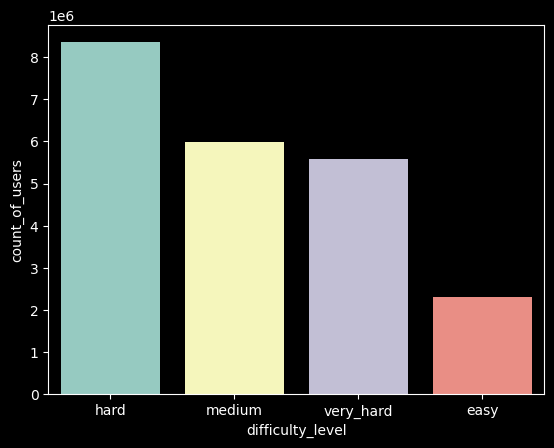

In [72]:
sns.barplot(data = level_graff, x='difficulty_level', y ='count_of_users')

Ми пам'ятаємо, що це в першу чергу вибірка. Але, глянувши на мої класифікації, можна побачити, що на складному рівні, ймовірно, сидить більше людей. Можливо, я встановив не дуже великий поріг для складного рівня, але за даними можна побачити, що на середньому та важкому рівнях користувачів більше. Для них цікавіше проводити час на більш вимогливих рівнях, ніж швидко проходити прості.

<Axes: xlabel='level'>

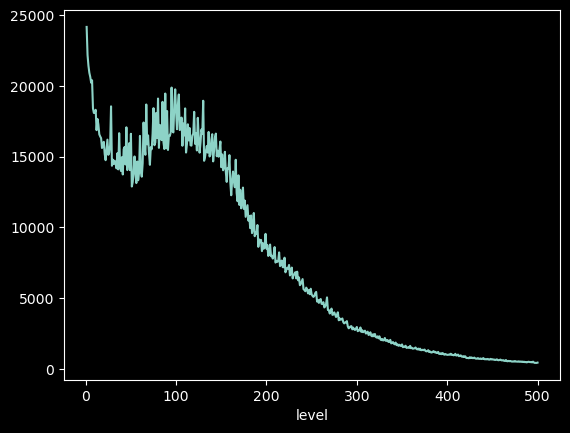

In [73]:
df.groupby('level')['user_id'].nunique().plot()

Зазвичай після так званого піку користувачі або покидають гру, або, можливо, хтось все ж таки досягає максимального рівня.

In [74]:
df.user_id.nunique()*31

6078728

переведемо дату зі строки і формат дати

In [75]:
df['dt'] = pd.to_datetime(df['event_time']/1000,unit='s')

In [76]:
df['dt'] = df['dt'].dt.date

In [77]:
df.head()

,user_id,action,level,event_time,action_bool,dt
0,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640,1,2017-12-01
1,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640,1,2017-12-01
2,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640,1,2017-12-01
3,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640,1,2017-12-01
4,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640,1,2017-12-01


In [78]:
t = df.groupby('user_id')['dt'].min().reset_index()

In [79]:
t.head()

,user_id,dt
0,M000MjVPdEM0MzMzNzA3MTAyMDE5MQ,2017-12-14
1,M000Y3dYeUUyMjIxODE3MTAyOTAwMQ,2017-12-02
2,M001QWtGRzUzMDQwMzI3MTAyMjE3MA,2017-12-20
3,M001TWRFNWc5MjQ1MDI3MTAyMjE5MA,2017-12-09
4,M001VTlGalU5MzcwMTI3MTAyMjE5Mg,2017-12-29


kagorts

In [80]:
t.groupby('dt')['user_id'].count().head()

dt
2017-12-01    40112
2017-12-02    16548
2017-12-03    12762
2017-12-04     8459
2017-12-05     4464
Name: user_id, dtype: int64

Дані припадають на період новорічних свят, які мають свою власну історію та специфіку. Мені здається, що в останні дні старого року і перші дні нового, безумовно, активність користувачів знизиться.

<Axes: xlabel='dt'>

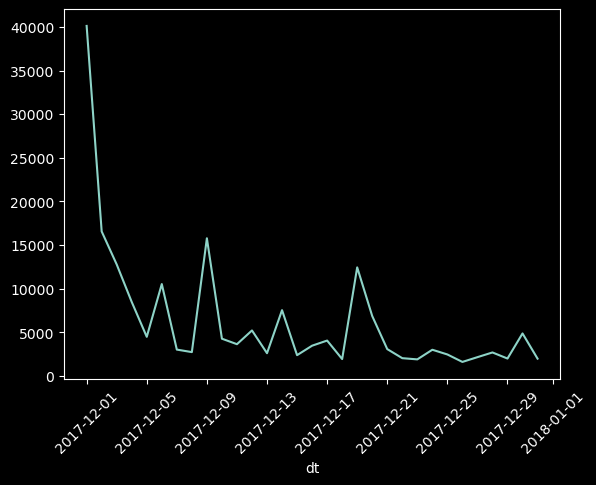

In [81]:
t.groupby('dt')['user_id'].count().plot(rot=45)

Як я казав, не можна впевнено стверджувати, що вони зареєструвались в цей місяць. Це лише вибірка даних.

під кінець місяця кількість унікальних користувачів падає

<Axes: xlabel='dt'>

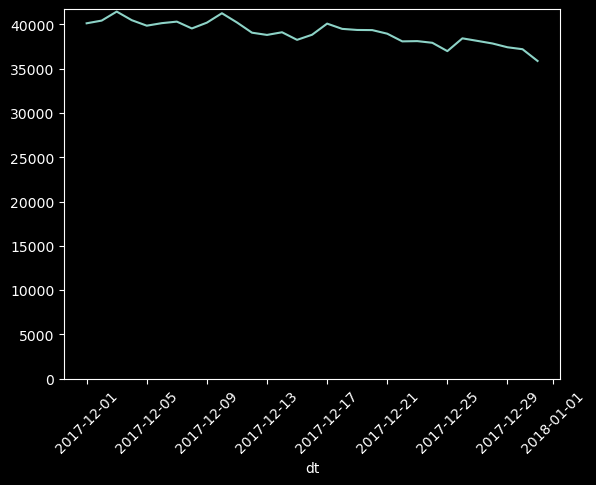

In [82]:
df.groupby('dt')['user_id'].nunique().plot(rot=45,ylim=0)

передноворічні місяці завжди дивні у бізнесі

це дата часу завантаження з пристроїв

людям просто може набридати грати та до 500 рівня мало хто доходить

як варіант можно було б відкинути корисувачів які прийшли чисто вбити час, і подивитися більше вже на хвіст

In [83]:
df['action_bool'] = df.action.replace('failed',1).replace('completed',0)

In [96]:
df.head()

,user_id,action,level,event_time,action_bool,dt
0,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640,1,2017-12-01
1,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640,1,2017-12-01
2,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640,1,2017-12-01
3,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640,1,2017-12-01
4,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640,1,2017-12-01


In [98]:
t = df.groupby(['level','user_id']).agg({'action_bool':'count'})

In [99]:
t.head()

action_bool
level user_id                                    
1     M001TWRFNWc5MjQ1MDI3MTAyMjE5MA            1
      M001VTlGalU5MzcwMTI3MTAyMjE5Mg            1
      M010Z2VmOFgzMzgwMTI3MTAyMjE4Mg            1
      M01QQlBMVmo1NTcyODA3MTAyMjE4MQ            1
      M01TMDNDdzA0MDkwNzE3MTAyMjE2MA            1

In [100]:
t = t.reset_index()

In [101]:
t.head()

,level,user_id,action_bool
0,1,M001TWRFNWc5MjQ1MDI3MTAyMjE5MA,1
1,1,M001VTlGalU5MzcwMTI3MTAyMjE5Mg,1
2,1,M010Z2VmOFgzMzgwMTI3MTAyMjE4Mg,1
3,1,M01QQlBMVmo1NTcyODA3MTAyMjE4MQ,1
4,1,M01TMDNDdzA0MDkwNzE3MTAyMjE2MA,1


In [105]:
tt = t.groupby('level')['action_bool'].agg(['count','mean','median'])

<Axes: xlabel='level'>

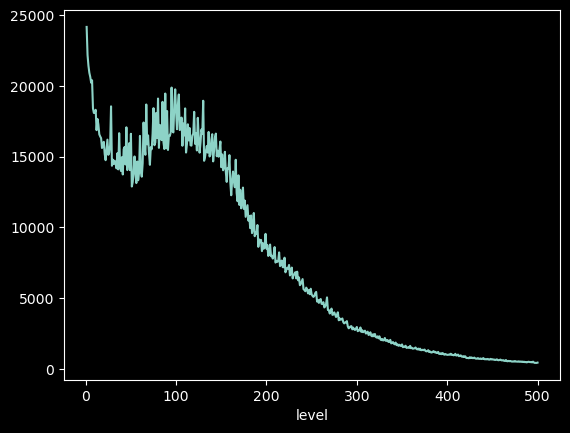

In [106]:
tt['count'].plot()

<Axes: xlabel='level'>

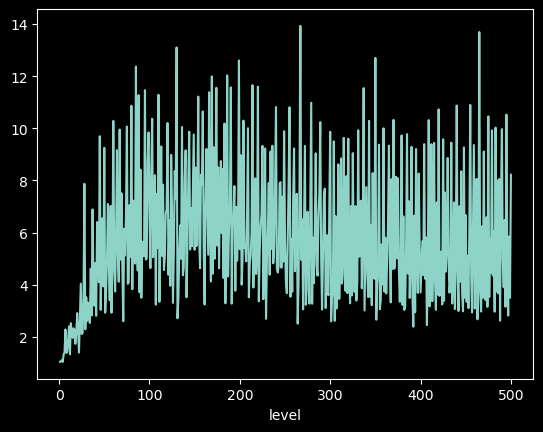

In [107]:
tt['mean'].plot()

Зверху я продублював графіки, які раніше розраховував. Давайте подивимося на медіану кількості користувачів на рівнях. Як я і казав, моя думка полягає в тому, що рівні чергуються від простих до складних, але факт того, що дуже мало людей досягають складних рівнів, навіть якщо вони існують, це факт

<Axes: xlabel='level'>

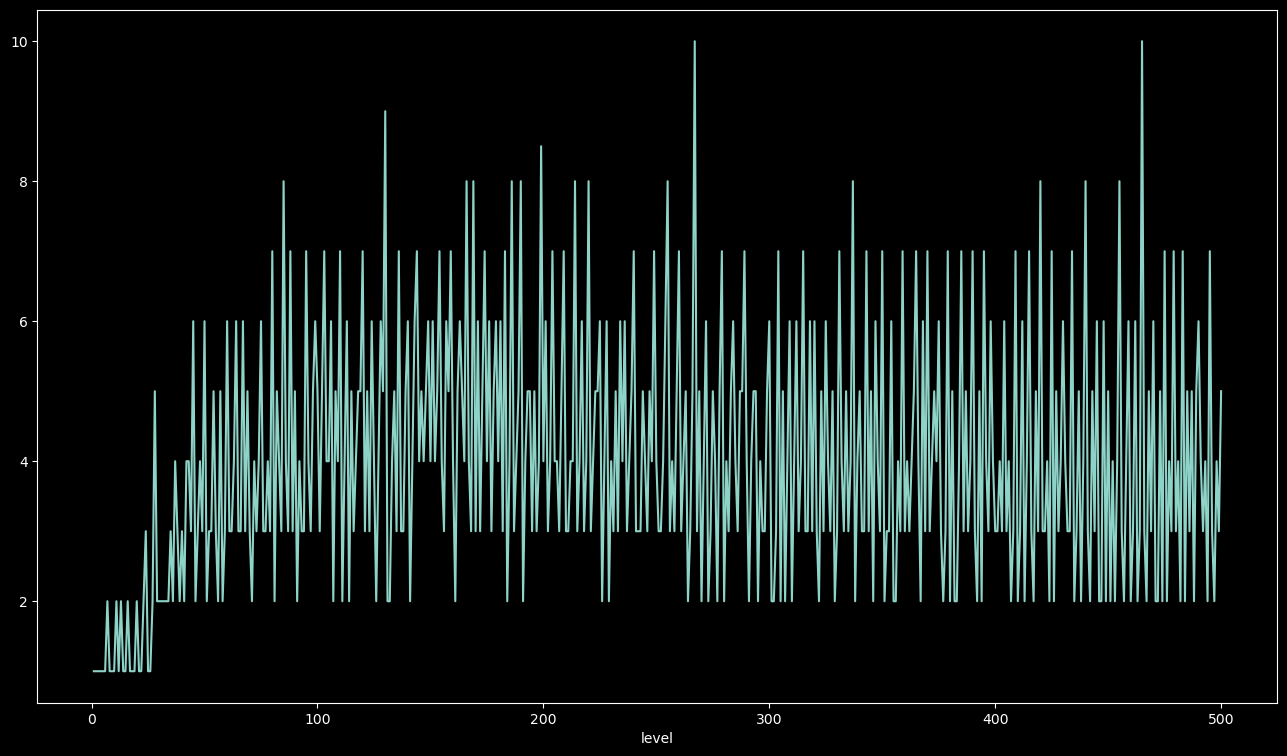

In [108]:
tt['median'].plot(figsize=(16,9))

In [110]:
tt = tt.reset_index('level')

<Axes: xlabel='level', ylabel='count'>

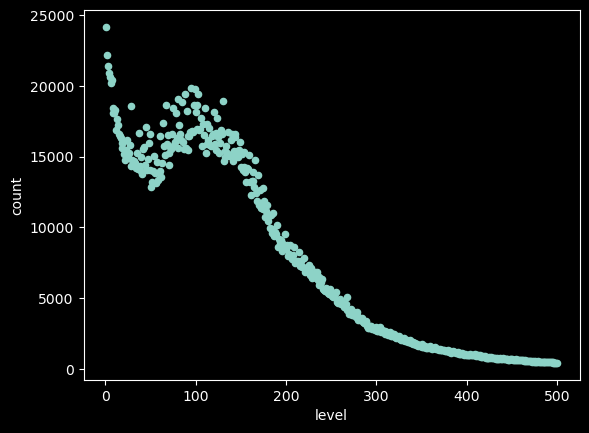

In [111]:
tt.plot(x='level',y='count',kind='scatter')

на цьому графіку щільність складних рівней видно краще

<Axes: >

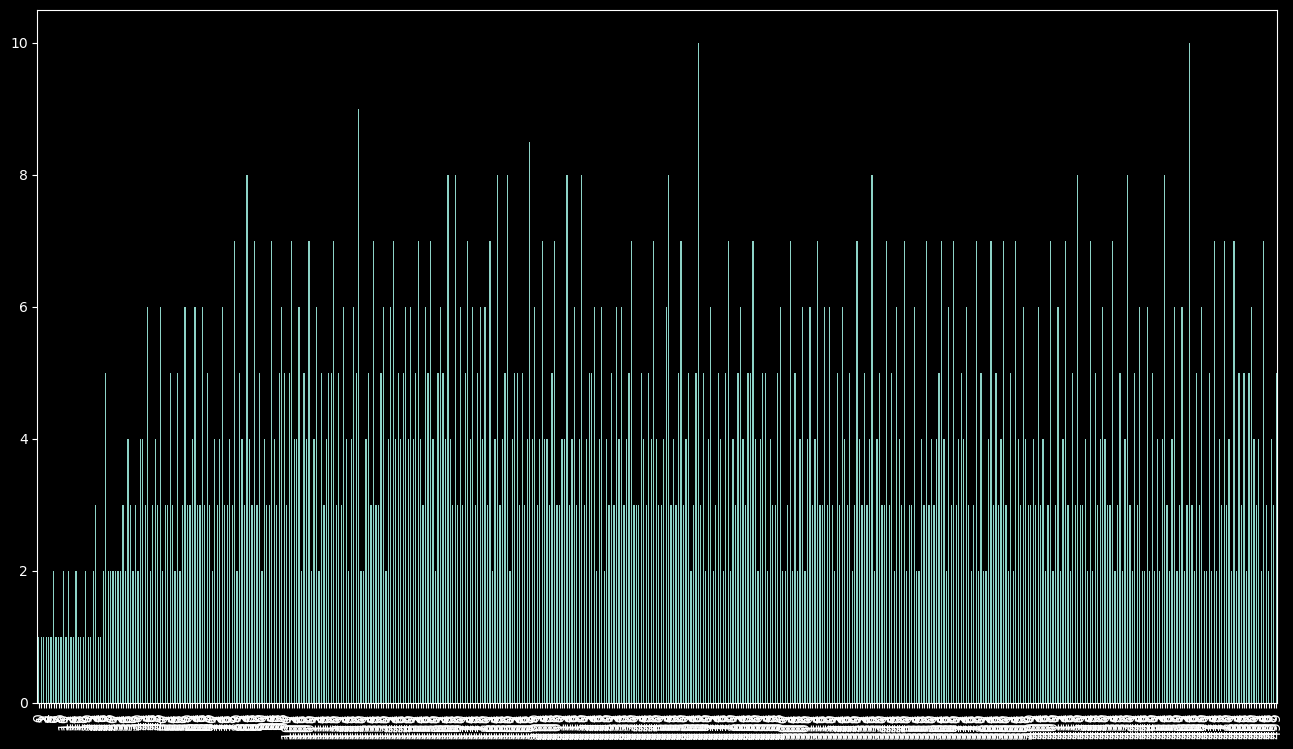

In [112]:
tt['median'].plot(kind='bar',figsize=(16,9))

Щодо останнього завдання, динаміка проходження рівнів буде йти від найбільшої ймовірності проходження до найменшої із збільшенням складності рівня.